<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Judy/European_Jax_1stock_Proof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T):
  return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

numstocks = 1
numsteps = 50
numpaths = 100000


rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

In [2]:
drift = jnp.array([0.05]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
T = 1.0
K = 1.0
S0 = 1.0
initial_stocks = jnp.array([S0]*numstocks)
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T)

DeviceArray(0.12329853, dtype=float32)

In [3]:
def optionvalueavg_Put(key, initial_stocks, numsteps, drift, r, cov, K, T):
  return jnp.mean((jnp.maximum(K - jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1),0)) * jnp.exp(-r[0] * T))

In [4]:
optionvalueavg_Put(key, initial_stocks, numsteps, drift, r, cov, K, T)

DeviceArray(0.07445544, dtype=float32)

## Change S

(r = 0.05, sigma = 0.25, T = 1, K = 0.8)

In [5]:
drift = jnp.array([0.05]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
T = 1.0
K = 0.8

Price_ChangeS = np.array([])
for i in range(0,100,1):
  ii = i/100
  initial_stocks = jnp.array([ii]*numstocks)
  #print(initial_stocks)
  fast_simple = jax.jit(Brownian_motion, static_argnums=2)
  keys = jax.random.split(key, numpaths)
  batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
  Price_ChangeS = np.append(Price_ChangeS,optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

In [7]:
def BS_formula(stock_price, stock_strike, risk_free_rate, dividend_rate, sigma, time):
    d1 = (np.log(stock_price / stock_strike) + ((risk_free_rate - dividend_rate + ((sigma ** 2) / 2)) * time)) / (sigma * (time ** 0.5))
    d2 = d1 - sigma * (time ** 0.5)
    call = stock_price * math.exp(-dividend_rate * time) * norm.cdf(d1) - stock_strike * math.exp(-risk_free_rate * time) * norm.cdf(d2)
    return call

In [8]:
Price_ChangeS_BS = np.array([])
for i in range(0,100,1):
  ii = i/100
  Price_ChangeS_BS = np.append(Price_ChangeS_BS,BS_formula(ii,K,r,0,0.25,T))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5, 1.0, 'Difference between Jax Price and BS Price When S0 Is Changing(K = 0.8) ')

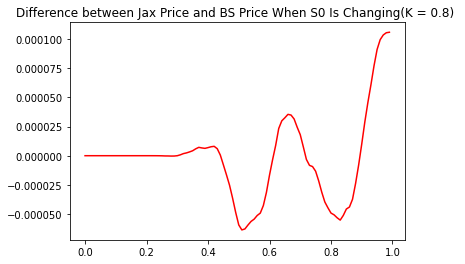

In [20]:
plt.plot(np.array(range(0, 100, 1))/100,(Price_ChangeS - Price_ChangeS_BS),'red')
plt.title('Difference between Jax Price and BS Price When S0 Is Changing(K = 0.8) ')

Text(0.5, 1.0, 'Changing of Option Price When S0 Is Changing(K = 0.8) ')

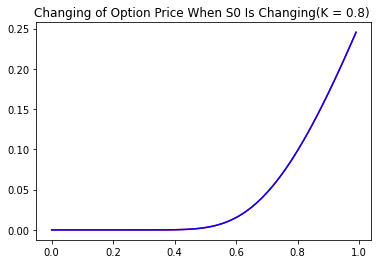

In [19]:
plt.plot(np.array(range(0, 100, 1))/100,Price_ChangeS,'red')
plt.plot(np.array(range(0, 100, 1))/100,Price_ChangeS_BS,'blue')

plt.title('Changing of Option Price When S0 Is Changing(K = 0.8) ')

## Change K

(r = 0.05, sigma = 0.25, T = 1, S = 0.5)

In [14]:
drift = jnp.array([0.05]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
T = 1.0
initial_stocks = jnp.array([0.5]*numstocks)

Price_ChangeK = np.array([])
for i in range(1,100,1):
  #print(i)
  ii = i/100
  K = ii
  fast_simple = jax.jit(Brownian_motion, static_argnums=2)
  keys = jax.random.split(key, numpaths)
  batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
  Price_ChangeK = np.append(Price_ChangeK,optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

In [11]:
# plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeK,'red')
# plt.title('Changing of Option Price When K Is Changing(S = 0.5)')

In [15]:
Price_ChangeK_BS = np.array([])
for i in range(1,100,1):
  #print(i)
  ii = i/100
  Price_ChangeK_BS = np.append(Price_ChangeK_BS,BS_formula(0.5,ii,r,0,0.25,T))

Text(0.5, 1.0, 'Difference between Jax Price and BS Price When K Is Changing(S = 0.5)')

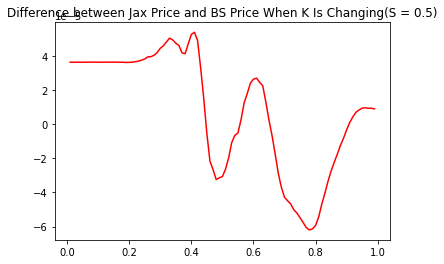

In [33]:
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeK - Price_ChangeK_BS,'red')

plt.title('Difference between Jax Price and BS Price When K Is Changing(S = 0.5)')

Text(0.5, 1.0, 'Changing of Option Price When K Is Changing(S = 0.5)')

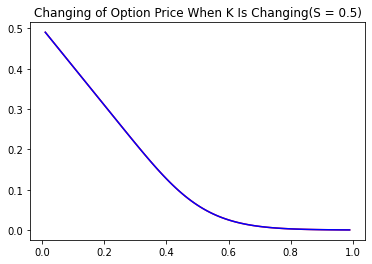

In [21]:
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeK,'red')
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeK_BS,'blue')
plt.title('Changing of Option Price When K Is Changing(S = 0.5)')

## Change r

(sigma = 0.25, T = 1, S = 0.5, K = 0.8)


In [26]:
cov = jnp.identity(numstocks)*0.25*0.25
T = 1.0
initial_stocks = jnp.array([0.5]*numstocks)
K = 0.8

Price_ChangeR = np.array([])
for i in range(1,100,1):
  #print(i)
  ii = i/100
  drift = jnp.array([ii]*numstocks)
  r = drift
  fast_simple = jax.jit(Brownian_motion, static_argnums=2)
  keys = jax.random.split(key, numpaths)
  batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
  Price_ChangeR = np.append(Price_ChangeR,optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

In [27]:
Price_ChangeR_BS = np.array([])
for i in range(1,100,1):
  #print(i)
  ii = i/100
  Price_ChangeR_BS = np.append(Price_ChangeR_BS,BS_formula(0.5,K,ii,0,0.25,T))

Text(0.5, 1.0, 'Difference between Jax Price and BS Price When R Is Changing')

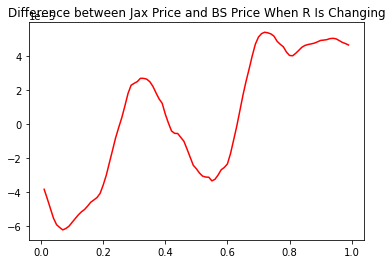

In [29]:
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeR - Price_ChangeR_BS,'red')

plt.title('Difference between Jax Price and BS Price When R Is Changing')

Text(0.5, 1.0, 'Changing of Option Price When R Is Changing')

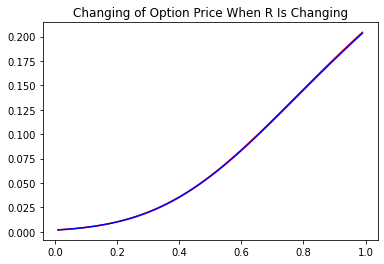

In [ ]:
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeR,'red')
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeR_BS,'blue')
plt.title('Changing of Option Price When R Is Changing')

## Change Sigma

(r = 0.05, T = 1, S = 0.5, K = 0.8)

In [30]:
drift = jnp.array([0.05]*numstocks)
r = drift
T = 1.0
initial_stocks = jnp.array([0.5]*numstocks)
K = 0.8

Price_ChangeSig = np.array([])
for i in range(1,100,1):
  #print(i)
  ii = i/100
  cov = jnp.identity(numstocks)*ii*ii

  fast_simple = jax.jit(Brownian_motion, static_argnums=2)
  keys = jax.random.split(key, numpaths)
  batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
  Price_ChangeSig = np.append(Price_ChangeSig,optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

In [31]:
Price_ChangeSig_BS = np.array([])
for i in range(1,100,1):
  #print(i)
  ii = i/100
  Price_ChangeSig_BS = np.append(Price_ChangeSig_BS,BS_formula(0.5,K,r,0,ii,T))

Text(0.5, 1.0, 'Difference between Jax Price and BS Price When Sigma Is Changing')

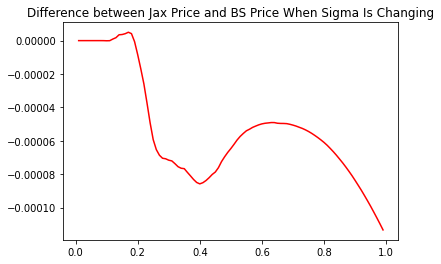

In [32]:
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeSig - Price_ChangeSig_BS,'red')

plt.title('Difference between Jax Price and BS Price When Sigma Is Changing')

Text(0.5, 1.0, 'Changing of Option Price When Sigma Is Changing')

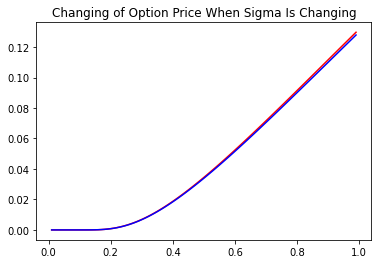

In [ ]:
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeSig,'red')
plt.plot(np.array(range(1, 100, 1))/100,Price_ChangeSig_BS,'blue')
plt.title('Changing of Option Price When Sigma Is Changing')